In [1]:
import numpy as np
import scipy
import scipy.io as io
from scipy.ndimage.filters import gaussian_filter
import os
import glob
from matplotlib import pyplot as plt
import h5py
import PIL.Image as Image
from matplotlib import cm as CM


#partly borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(img,points):
    '''
    This code use k-nearst, will take one minute or more to generate a density-map with one thousand people.

    points: a two-dimension list of pedestrians' annotation with the order [[col,row],[col,row],...].
    img_shape: the shape of the image, same as the shape of required density-map. (row,col). Note that can not have channel.

    return:
    density: the density-map we want. Same shape as input image but only has one channel.

    example:
    points: three pedestrians with annotation:[[163,53],[175,64],[189,74]].
    img_shape: (768,1024) 768 is row and 1024 is column.
    '''
    img_shape=[img.shape[0],img.shape[1]]
    print("Shape of current image: ",img_shape,". Totally need generate ",len(points),"gaussian kernels.")
    density = np.zeros(img_shape, dtype=np.float32)
    gt_count = len(points)
    if gt_count == 0:
        return density

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(points, k=4)

    print ('generate density...')
    for i, pt in enumerate(points):
        pt2d = np.zeros(img_shape, dtype=np.float32)
        if int(pt[1])<img_shape[0] and int(pt[0])<img_shape[1]:
            pt2d[int(pt[1]),int(pt[0])] = 1.
        else:
            continue
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density


<ipython-input-1-145ff2258e11>:4: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2


class CrowdDataset(Dataset):
    '''
    crowdDataset
    '''
    def __init__(self,img_root,gt_dmap_root,gt_downsample=1):
        '''
        img_root: the root path of img.
        gt_dmap_root: the root path of ground-truth density-map.
        gt_downsample: default is 0, denote that the output of deep-model is the same size as input image.
        '''
        self.img_root=img_root
        self.gt_dmap_root=gt_dmap_root
        self.gt_downsample=gt_downsample

        self.img_names=[filename for filename in os.listdir(img_root) \
                           if os.path.isfile(os.path.join(img_root,filename))]
        self.n_samples=len(self.img_names)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
      assert index <= len(self), 'index range error'
      img_name = self.img_names[index]
      img = plt.imread(os.path.join(self.img_root, img_name))
      print(img.shape)
      # Handle grayscale image case
      if len(img.shape) == 2:  # If image is grayscale
          img = img[:, :, np.newaxis]  # Expand dimensions
          img = np.concatenate((img, img, img), 2)  # Convert to 3 channels (RGB)

      gt_dmap = np.load(os.path.join(self.gt_dmap_root, img_name.replace('.jpg', '.npy')))
      print(gt_dmap.shape)
      # If downsampling is required
      if self.gt_downsample > 1:
          ds_rows = int(img.shape[0] // self.gt_downsample)
          ds_cols = int(img.shape[1] // self.gt_downsample)
          img = cv2.resize(img, (ds_cols * self.gt_downsample, ds_rows * self.gt_downsample))
          gt_dmap = cv2.resize(gt_dmap, (ds_cols, ds_rows))

      # Convert to tensors
      img = img.transpose((2, 0, 1))  # Convert to (C, H, W) format for PyTorch
      gt_dmap = gt_dmap[np.newaxis, :, :]  # Add channel dimension to density map

      # Create tensors for PyTorch
      img_tensor = torch.tensor(img, dtype=torch.float)
      gt_dmap_tensor = torch.tensor(gt_dmap, dtype=torch.float)

      return img_tensor, gt_dmap_tensor


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        original_size = img_tensor.size()[2:]
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        # x = F.interpolate(x, size=original_size, mode='bilinear', align_corners=False)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

(1080, 1920)


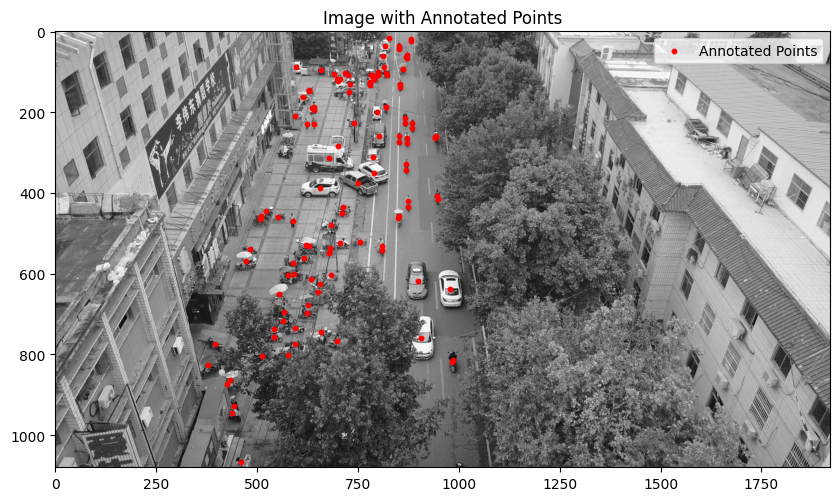

Shape of current image:  [1080, 1920] . Totally need generate  127 gaussian kernels.
generate density...


<ipython-input-1-145ff2258e11>:52: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.
(1080, 1920)


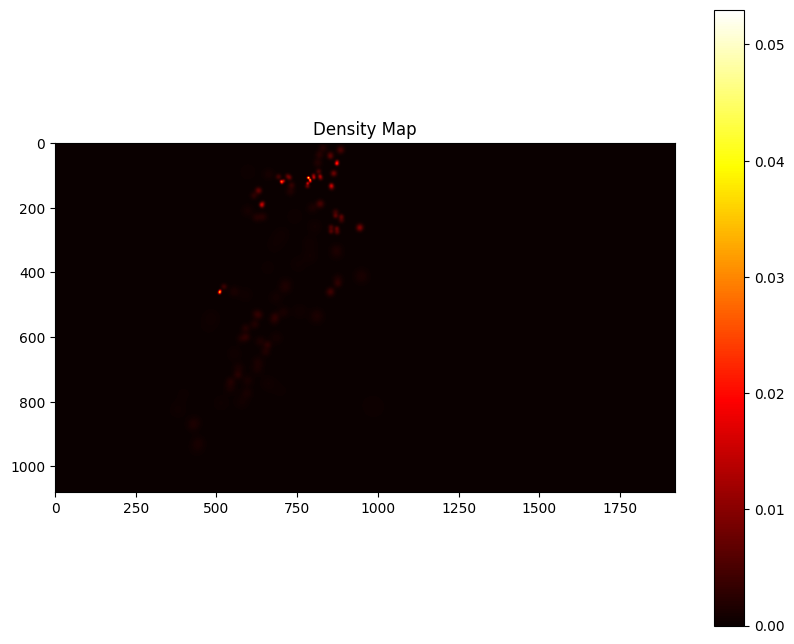

In [5]:
# Step 1: Load image
image_path = '/content/0000001_02999_d_0000005.jpg'  # Replace with the actual path
img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
print(img.shape)
# Step 2: Load the points from the notepad file and convert to numpy array
points = []
with open('/content/0000001_02999_d_0000005.txt', 'r') as f:  # Replace with actual path to points file
    for line in f:
        x,y,w,h,z,c = map(int, line.strip().split(','))  # Assuming coordinates are in 'x,y' format
        if z == 1:
          points.append([x+w/2, y+h/2])

points = np.array(points)  # Convert the list of points to a numpy array

# Step 3: Plot the image with annotated points
plt.figure(figsize=(10, 8))
plt.imshow(img, cmap='gray')
plt.scatter(points[:, 0], points[:, 1], color='red', s=10, label='Annotated Points')
plt.title('Image with Annotated Points')
plt.legend()
plt.show()

# Step 4: Generate the density map using the gaussian_filter_density function
density_map_1 = gaussian_filter_density(img, points)
print(density_map_1.shape)
# Step 5: Plot the density map
plt.figure(figsize=(10, 8))
plt.imshow(density_map_1, cmap='hot')
plt.title('Density Map')
plt.colorbar()
plt.show()

<ipython-input-34-47d613364fc1>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mcnn.load_state_dict(torch.load(model_param_path, map_location=torch.device('cpu')))


model_param_path:model.param MAE:2363.70703125
0


<ipython-input-34-47d613364fc1>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mcnn.load_state_dict(torch.load(model_param_path, map_location=torch.device('cpu')))


Predicted density map saved as NumPy array at predicted_density_map_3.npy


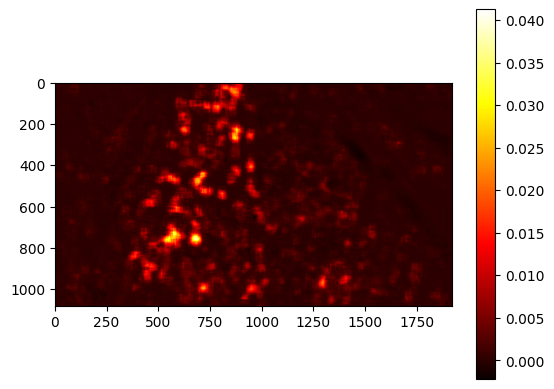

Predicted density map saved at output_density_maps/predicted_density_map_3.png


In [34]:
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.cm as CM
import numpy as np

def cal_mae(img_root, gt_dmap_root, model_param_path):
    '''
    Calculate the MAE of the test data.
    img_root: the root of test image data.
    gt_dmap_root: the root of test ground truth density-map data.
    model_param_path: the path of specific mcnn parameters.
    '''
    device = torch.device("cpu")
    mcnn = MCNN().to(device)

    # Load the model parameters to CPU
    mcnn.load_state_dict(torch.load(model_param_path, map_location=torch.device('cpu')))

    dataset = CrowdDataset(img_root, gt_dmap_root,1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    mcnn.eval()
    mae = 0

    with torch.no_grad():
        for i, (img, gt_dmap) in enumerate(dataloader):
            img = img.to(device)
            gt_dmap = gt_dmap.to(device)
            # forward propagation
            et_dmap = mcnn(img)
            original_shape = img.shape[2:]  # Store original shape
            if original_shape[0] % 4 == 0 and original_shape[1] % 4 == 0:
                # If both dimensions are multiples of 4, use cubic interpolation
                et_dmap = F.interpolate(et_dmap, scale_factor=4, mode='bicubic', align_corners=False)
            else:
                # Otherwise, resize directly to original shape
                et_dmap = F.interpolate(et_dmap, size=original_shape, mode='bilinear', align_corners=False)
            mae += abs(et_dmap.data.sum() - gt_dmap.data.sum()).item()
            del img, gt_dmap, et_dmap

    print("model_param_path:" + model_param_path + " MAE:" + str(mae / len(dataloader)))

def estimate_density_map(img_root, gt_dmap_root, model_param_path, index):
    '''
    Show and save one estimated density-map.
    img_root: the root of test image data.
    gt_dmap_root: the root of test ground truth density-map data.
    model_param_path: the path of specific mcnn parameters.
    index: the order of the test image in test dataset.
    '''
    device = torch.device("cpu")
    mcnn = MCNN().to(device)

    # Load the model parameters to CPU
    mcnn.load_state_dict(torch.load(model_param_path, map_location=torch.device('cpu')))

    dataset = CrowdDataset(img_root, gt_dmap_root, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    mcnn.eval()

    for i, (img, gt_dmap) in enumerate(dataloader):
        print(i)
        img = img.to(device)
        gt_dmap = gt_dmap.to(device)

        # Forward pass through the model
        et_dmap = mcnn(img).detach()
        original_shape = img.shape[2:]  # Store original shape
        if original_shape[0] % 4 == 0 and original_shape[1] % 4 == 0:
            # If both dimensions are multiples of 4, use cubic interpolation
            et_dmap = F.interpolate(et_dmap, scale_factor=4, mode='bicubic', align_corners=False)
        else:
            # Otherwise, resize directly to original shape
            et_dmap = F.interpolate(et_dmap, size=original_shape, mode='bilinear', align_corners=False)

        # Convert predicted density map to NumPy array for saving
        et_dmap = et_dmap.squeeze(0).squeeze(0).cpu().numpy()
        # Upsample the density map


        predicted_density_filename = f"predicted_density_map_{index}.npy"
        np.save(os.path.join("output_density_maps", predicted_density_filename), et_dmap)
        print(f"Predicted density map saved as NumPy array at {predicted_density_filename}")

        # Display and save the predicted density map
        plt.imshow(et_dmap, cmap='hot')
        plt.colorbar()

        # Save the image
        output_path = os.path.join("output_density_maps", f"predicted_density_map_{index}.png")
        plt.savefig(output_path)
        plt.show()

        print(f"Predicted density map saved at {output_path}")
        break


if __name__ == "__main__":
    torch.backends.cudnn.enabled = False
    img_root = 'images'
    gt_dmap_root = 'density_maps'
    os.makedirs(img_root, exist_ok=True)
    os.makedirs(gt_dmap_root, exist_ok=True)

    # Save the image (as .jpg) and density map (as .npy)
    image_path = '0000001_02999_d_0000005.jpg'  # Replace with the actual path
    img = np.array(Image.open(image_path).convert('L'))  # Convert to grayscale
    density_map = np.load('0000001_02999_d_0000005.npy')  # Load your density map .npy file
    # density_map = density_map_1
    image_filename = 'image_01.jpg'
    density_filename = 'image_01.npy'
    # Save image and density map
    plt.imsave(os.path.join(img_root, image_filename), img, cmap='gray')
    np.save(os.path.join(gt_dmap_root, density_filename), density_map)
    os.makedirs("output_density_maps", exist_ok=True)  # Create output folder if it doesn't exist
    model_param_path = 'model.param'

    # Test MAE calculation
    cal_mae(img_root, gt_dmap_root, model_param_path)

    # Estimate and save the density map for a specific index
    predicted_density_map = estimate_density_map(img_root, gt_dmap_root, model_param_path, 3)


(1080, 1920)


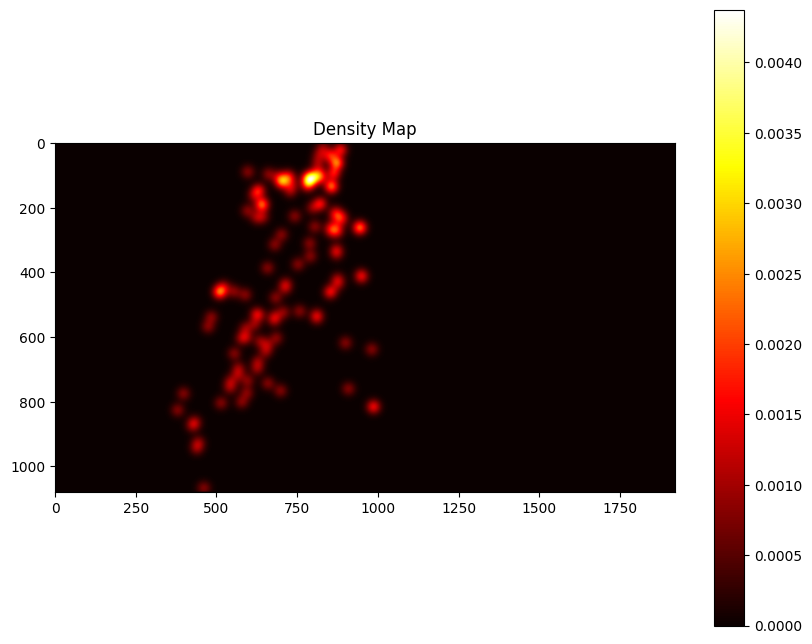

In [35]:
density = np.load('/content/output_density_maps/predicted_density_map_3.npy')
print(density.shape)
plt.figure(figsize=(10, 8))
plt.imshow(density_map, cmap='hot')
plt.title('Density Map')
plt.colorbar()
plt.show()